In [16]:
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
from skimage.feature import plot_matches
from collections import deque

from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
SAMPLE_NUMBER = 7

In [18]:
PATH       : Path = Path.cwd()/"samples"/str(SAMPLE_NUMBER)  # directory of the images
IMG_FORMAT : str  = "jpg"                                    # e.g. jpg/jpeg/png...
OUTPATH = PATH/'output'
OUTPATH.mkdir(exist_ok=True, parents=True)

IMAGES = [cv2.imread(str(p)) for p in sorted([x for x in PATH.iterdir() if x.suffix == ".jpg"])]
N = len(IMAGES)

In [19]:
im = IMAGES
hpts = [ANMS(*harris_points(im)) for im in IMAGES]

In [20]:
desc = [get_descriptors(im, h) for im, h in zip(IMAGES, hpts)]

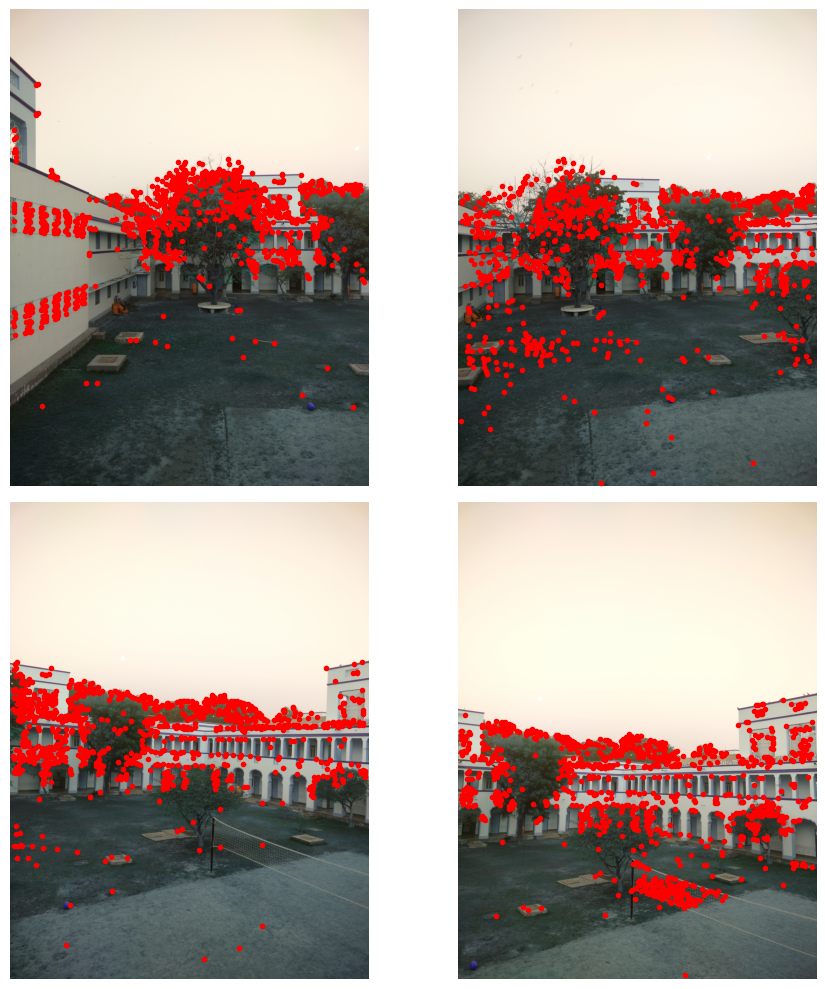

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(im[0])
ax[0, 1].imshow(im[1])
ax[1, 0].imshow(im[2])
ax[1, 1].imshow(im[3])
ax[0,0].plot(hpts[0][:, 1], hpts[0][:, 0], 'r.')
ax[0,1].plot(hpts[1][:, 1], hpts[1][:, 0], 'r.')
ax[1,0].plot(hpts[2][:, 1], hpts[2][:, 0], 'r.')
ax[1,1].plot(hpts[3][:, 1], hpts[3][:, 0], 'r.')
for a in ax.flatten(): a.set_axis_off()
plt.tight_layout()

In [22]:
H_matrix = np.zeros((N, N), dtype=object)
Weight_matrix = np.zeros((N,N), dtype=int)

for i in range(0, N):
    for j in range(i+1, N):
        matches = match_descriptors(desc[i], desc[j])
        mptsi = hpts[i][matches[:, 0]]
        mptsj = hpts[j][matches[:, 1]]
        H, W = RANSAC2(mptsi, mptsj)
        H_matrix[i, j] = H
        Weight_matrix[i, j] = W

In [23]:
from utils import *

In [26]:
edges = MST(Weight_matrix)
graph = adjacency_list_from_edges(edges, N)
graph

[[1], [0, 6], [5, 3], [2, 4], [3], [6, 2], [1, 5]]

In [27]:
DP = [None] * N
DP[0] = np.eye(3)
bfs = deque([0])
order = []
while bfs:
    i = bfs.popleft()
    order.append(i)
    for j in graph[i]:
        if DP[j] is None:
            if j > i:
                DP[j] = DP[i] @ H_matrix[i, j]
            else:
                DP[j] = DP[i] @ np.linalg.inv(H_matrix[j, i])
            bfs.append(j)

In [28]:
image_homography_pairs = list(zip(IMAGES, DP))

In [29]:
warped = warp_images(image_homography_pairs)

In [31]:
final_image = blend_image(warped[order[0]], warped[order[1]])
for i in range(2, N):
    final_image = blend_image(final_image, warped[order[i]])

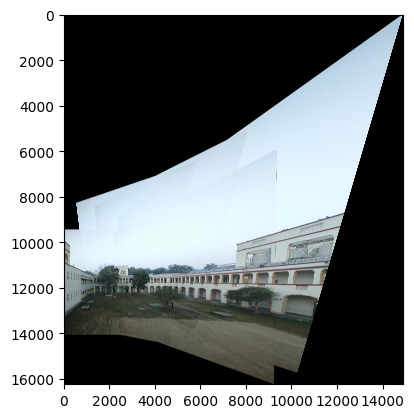

In [33]:
plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))

In [32]:
cv2.imwrite(str(OUTPATH/'multi_auto.jpg'), final_image)

True